# Statistical Processing for Halo Distribution
## Zhuowen Zhang, first created March 22, 2018


In [97]:
import numpy as np

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt
from code.plot_utils import plot_pretty
plot_pretty()
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
from code.halo_shape_calc import quad_moment
from code.lightcone_query_ra_dec import query_file, read_radial_bin
from code.setup.setup import data_home_dir
from code.setup.setup import code_home_dir
import pyfits
datadir = data_home_dir()
codedir = code_home_dir()


import astropy.io.fits as pyfits
import ConfigParser
import healpy as hp
import treecorr
import os

## Importing Halo File
If re-run sampling, for instance if you change the number of bins in mass pdf, or the mass cutoffs, you will need to start from here. 

In [140]:
#Combining data for redMapper selected halos
try:
    filename = 'halos_shape_allz.npy'
    halos_shape = np.load(datadir+filename)
except IOError:
    print"Error: File {0} cannot be opened".format(filename)
else:
    print"Created from {} record array".format(filename)
    print "Number of halos is {}".format(len(halos_shape))

    
#Data for random halos. Use low-redshift ones for now
#Todo: Combine low/high-z for random halos

try:
    filename = 'halos_shape_rand.npy'
    halos_shape_rand = np.load(datadir+filename)
except IOError:
    print"Error: File {0} cannot be opened".format(filename)
else:
    print "Created from {} record array".format(filename)
    print "Number of halos is {}".format(len(halos_shape_rand))

Created from halos_shape_allz.npy record array
Number of halos is 23997
Created from halos_shape_rand.npy record array
Number of halos is 100000


## Extract relevant quantities from data

#### For redMapper selected halos

In [141]:
#check properties of halos with shapes not converged
ind_not_conv = np.where(halos_shape['converge'] == False)

#print 'Positions not converge:', np.where(halos_shape['converge'] != 1)
conv_cut = np.where(halos_shape['converge']==True)
halos_shape = halos_shape[conv_cut]
#print 'After cut positions not converged:', np.where(halos_shape['converge'] != 1)
m_cut = np.where(halos_shape['M200b'] < 1e15)
halos_shape = halos_shape[m_cut]
halos_num = len(halos_shape)
print 'Number of halos after cuts is ', halos_num


#Relevant quantities to extract and plot
########################################

#Axis len and dir
halos_RA = halos_shape['halos_RA']; halos_DEC = halos_shape['halos_DEC']
halos_coord = np.array([halos_RA, halos_DEC]).T
axes_len = halos_shape['axes_len']
axes_dir = halos_shape['axes_dir']
halos_dir = halos_shape['halos_dir']
q = axes_len[:,2]/axes_len[:,0]
s = axes_len[:,1]/axes_len[:,0]

#Mass
halos_M = halos_shape['M200b']


#Orientation PDF
major_dir = axes_dir[:,2,:]

#absolute value of cosine of axis between major axis and LOS
#For redMapper selected halos
cos_i = np.zeros(halos_num) #cos(i) in lingo of Osato 2017
for i in range(halos_num):
    halos_dir_mag = np.linalg.norm(halos_dir[i])
    major_mag = np.linalg.norm(major_dir[i]);
    cos_i[i] = np.abs(np.dot(major_dir[i],halos_dir[i])/(halos_dir_mag * major_mag))
#convert cosine to angle in degrees
#angle_los_halo = np.arccos(cos_i)*180/np.pi

Number of halos after cuts is  23668


#### For randomly selected halos
May need to redraw halos in random selection from each mass bin to re-produce identical mass pdf as redMapper

In [142]:
from numpy.random import choice

#Extract random halos
#check properties of halos with shapes not converged
ind_not_conv_rand = np.where(halos_shape_rand['converge'] == False)

#print 'Positions not converge:', np.where(halos_shape['converge'] != 1)
conv_cut_rand = np.where(halos_shape_rand['converge']==True)
halos_shape_rand = halos_shape_rand[conv_cut_rand]
halos_num_rand = len(halos_shape_rand)
#print 'After cut positions not converged:', np.where(halos_shape['converge'] != 1)
print 'Number of randomly selected halos after cuts is ', halos_num_rand

#mass
halos_M_rand = halos_shape_rand['M200b']


#bin the redMapper by mass
num_bin = 40
m_min = 13; m_max = 15
n_mass_hist, lnmass_bin_edge = np.histogram(np.log10(halos_M), num_bin, range=(m_min, m_max))
#Resampled statistics
rand_resamp_ind = np.array([], dtype=int)

for i in range(num_bin):
    lnmass_bin_low = lnmass_bin_edge[i]; lnmass_bin_high = lnmass_bin_edge[i+1]
    lnmass_bin_ind = np.where( (np.log10(halos_M_rand) < lnmass_bin_high) & \
                         (np.log10(halos_M_rand) >= lnmass_bin_low))[0]

    #Draw samples from randomly selected halos to match redMapper.
    #The two distributions may be off at large mass, so introduce arbitary cutoff at 10**13 and 10**15 Msun
    #Should not affect distribution too much as >99% are in the 13-15 range
    
    #Resample the distribution in the mass range to match number of halos in redMapper
    assert len(lnmass_bin_ind) >= 1, "No halos in random in this mass range"
    lnmass_bin_resamp_ind = choice(lnmass_bin_ind, size=n_mass_hist[i])
    rand_resamp_ind = np.concatenate((rand_resamp_ind, lnmass_bin_resamp_ind))

#print rand_resamp_ind
#halos_M_rand_resamp = halos_M_rand[rand_resamp_ind]
#print len(halos_M_rand_resamp)
    


Number of randomly selected halos after cuts is  76970


In [143]:
#Resample the random halos according to mass pdf of redMapper
halos_shape_rand = np.copy(halos_shape_rand[rand_resamp_ind])
halos_num_rand = len(halos_shape_rand)
print 'Number of resampled random halos is', halos_num_rand
print 'Number of redMapper halos in M range 13-15 is ', np.sum(n_mass_hist)

#Axis len and dir
halos_RA_rand = halos_shape_rand['halos_RA']; halos_DEC_rand = halos_shape_rand['halos_DEC']
halos_coord_rand = np.array([halos_RA_rand, halos_DEC_rand]).T
axes_len_rand = halos_shape_rand['axes_len']
axes_dir_rand = halos_shape_rand['axes_dir']
halos_dir_rand = halos_shape_rand['halos_dir']
q_rand = axes_len_rand[:,2]/axes_len_rand[:,0]
s_rand = axes_len_rand[:,1]/axes_len_rand[:,0]

#mass
halos_M_rand = halos_shape_rand['M200b']

#Orientation PDF
major_dir_rand = axes_dir_rand[:,2,:]

#Orientation
cos_i_rand = np.zeros(halos_num_rand) #cos(i) in lingo of Osato 2017
for i in range(halos_num_rand):
    halos_dir_mag_rand = np.linalg.norm(halos_dir_rand[i])
    major_mag_rand = np.linalg.norm(major_dir_rand[i]);
    cos_i_rand[i] = np.abs(np.dot(major_dir_rand[i],halos_dir_rand[i])/(halos_dir_mag_rand * major_mag_rand))

Number of resampled random halos is 23668
Number of redMapper halos in M range 13-15 is  23668


## Bins
Bin by cosine and lambda

In [144]:
##Cosine bins
#Bin by cos_i
cosi_num_bin = 5
cosi_bin_edge = np.linspace(0,1,cosi_num_bin+1)
cosi_bins = []
for i in range(cosi_num_bin):
    cosi_bins.append([cosi_bin_edge[i], cosi_bin_edge[i+1]])

#Bin halos_shape by cosi bins
cosi_bins_ind = []
for i, cosi_bin in enumerate(cosi_bins):
    cosi_bin_min = cosi_bin[0]; cosi_bin_max = cosi_bin[1]
    cosi_pos = np.where((cos_i >= cosi_bin_min) & (cos_i < cosi_bin_max))
    cosi_bins_ind.append(cosi_pos)  
    
#Richness bins
richness = halos_shape['richness']
lmda_max = np.max(richness)
lmda_bins = [[20,30],[30,50],[50,lmda_max]] #upper limit must match lower limit of next bin
num_lmda_bins = len(lmda_bins)
print 'Maximum richness after cuts is ', lmda_max

#Bin halos_shape by richness bins
lmda_bins_ind = []
for i, lmda_bin in enumerate(lmda_bins):
    #print i, lmda_bin
    lmda_bin_min = lmda_bin[0]; lmda_bin_max = lmda_bin[1]
    lmda_pos = np.where((richness >= lmda_bin_min) & (richness < lmda_bin_max))
    lmda_bins_ind.append(lmda_pos)

Maximum richness after cuts is  273.968


## Testing ellipticity with mass relation

#### Correlation between q and mass. 

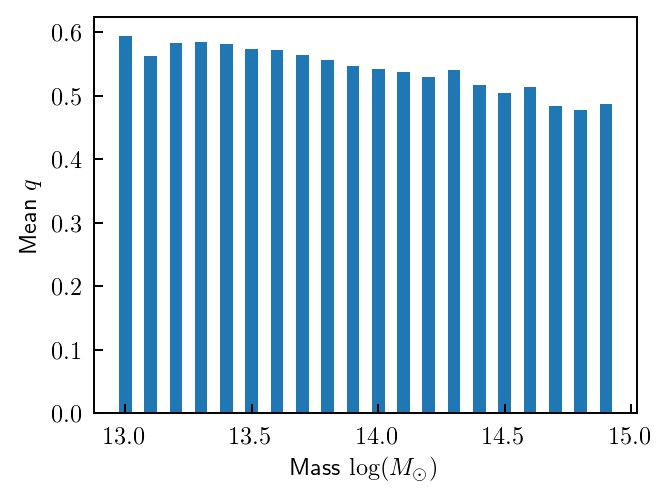

In [145]:
from scipy.stats import sem
#Test for random halos whether ellipticity q scales with mass. 
num_bin = 20
m_min = 13; m_max = 15
n_mass_hist, lnmass_bin_edge = np.histogram(np.log10(halos_M_rand), 20, range=(m_min, m_max))
#plt.hist(halos_M_rand, num_bin, range=(m_min, m_max), log=True)
#plt.show()

q_mean_bin = np.zeros(num_bin)
q_sem_bin = np.zeros(num_bin)
for i in range(num_bin):
    lnmass_bin_low = lnmass_bin_edge[i]; lnmass_bin_high = lnmass_bin_edge[i+1]
    q_bin_ind = np.where( (np.log10(halos_M_rand) < lnmass_bin_high) & \
                         (np.log10(halos_M_rand) >= lnmass_bin_low))
    q_mean_bin[i] = np.mean(q_rand[q_bin_ind])
    q_sem_bin[i] = sem(q_rand[q_bin_ind])
#print q_mean_bin
#print q_sem_bin

plt.figure(figsize=(4,3))
plt.bar(lnmass_bin_edge[0:-1], q_mean_bin, width=0.05)
plt.xlabel(r'Mass $\log(M_\odot)$')
plt.ylabel('Mean $q$')
plt.show()

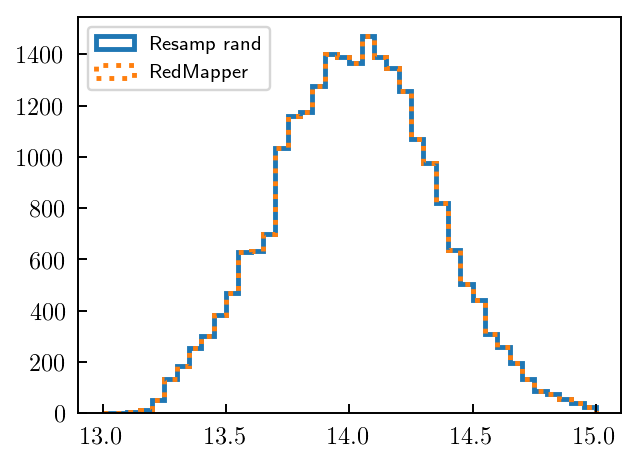

In [146]:
#Plot histogram to show resampling works
plt.figure(figsize=(4,3))
a, dummy1, c = plt.hist(np.log10(halos_M_rand), 40, range=(13,15), fill=False, histtype='step', linewidth=2, label='Resamp rand')
b, dummy2, c= plt.hist(np.log10(halos_M),40,range=(13,15), fill=False, histtype='step', \
         linestyle='dotted', linewidth=2, label='RedMapper')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## KMeans Jackknife Code

#### For redMapper selected halos

In [147]:
from code.kmeans_radec import kmeans, kmeans_sample

#First instantiate an instance of the class. Import the RA, DEC of the files and check for center. 
#To do: Halo file to import
#Use Yuanyuan's code to compute mean and error on angle and ellipticities. 

ncen = 5
cen_guess=np.zeros( (ncen, 2) )
ra_guesses = cen_guess[:,0]
dec_guesses = cen_guess[:,1]
km=kmeans(halos_coord, cen_guess)
#km.run(halos_coord, maxiter=100)


# results are saved in attributes
print "Convergence is ", km.converged
#print(km.centers, km.labels, km.distances)
print("copy of centers:",km.get_centers())

X (23668, 2)  centers (5, 2)  tol=1e-05  maxiter=100
43 iterations  cluster sizes: [4153 6461 6117 6937]
Convergence is  True
('copy of centers:', array([[145.36628723,  53.22717749],
       [ 87.55173492,  15.5425553 ],
       [ 84.43038177,  52.85417536],
       [ 38.68504333,  38.89712127],
       [  0.        ,   0.        ]]))


In [148]:
#Jackknife Resampling
#Jackknife reference: https://www.utdallas.edu/~herve/abdi-Jackknife2010-pretty.pdf
#Extract quantities from km object
ncen =40
km = kmeans_sample(halos_coord, ncen, verbose=0)
km_centers = km.get_centers()
km_labels= km.find_nearest(halos_coord)
km_ncen = km.get_ncen()

#Check properties
#print("found centers:", len(km.centers))
#print("converged?", km.converged)
#print("labels size:", km.labels.size)
#print("cluster sizes:", np.bincount(km.labels))
#print("shape of distances:", km.distances.shape)


#It's much better to build a record array or dictionary. 
#Each element outputs mean, number of samples and SE for each richness bin
num_bins = len(cosi_bins)
T_stat_arr = np.zeros(num_bins, dtype={'names':('q', 's', 'cos_i'),'formats':('(3,)f','(3,)f','(3,)f')})

#Build dummy array of test statistics to import to T_stat_arr
T_stat =[q, s, cos_i]
num_stat = len(T_stat)
T_arr =np.zeros((num_stat,num_bins,3)) #3 for mean, number of samples, and SE. Model as Student-t 

#Array for test_statistics
for i, name in enumerate(T_stat_arr.dtype.names):  
    for j in range(num_bins):
        T_jk_list = []
        cosi_bin_min = cosi_bins[j][0]; cosi_bin_max = cosi_bins[j][1]
        for k in range(km_ncen):
        #    print 'Working on the No. %i Jacknife sample out of %i, richness %f to %f' \
        #            %(i, km.get_ncen(), lmda_min, lmda_max)
            jackknife_cut = np.where((cos_i >= cosi_bin_min) & (cos_i <= cosi_bin_max) & (km_labels != k))
            T_k_cut = T_stat[i][jackknife_cut]
            T_jk_list.append(T_k_cut)
        T_jk_list = np.asarray(T_jk_list)

        #jackknife estimator of mean
        T_rdu_arr = np.array([np.mean(T_jk_list[x]) for x in range(len(T_jk_list))]) #array of test statistic for ncen reduced jackknife sample
        T_num_samp = len(T_rdu_arr) #Number of samples 
        T_jk_mean = np.mean(T_rdu_arr)
        T_jk_var = np.var(T_rdu_arr, ddof=1)
        T_jk_std = np.std(T_rdu_arr, ddof=1) #ddof = 1 so that divide by (N-1), sample standard deviation
        T_jk_SE = (km_ncen-1.)/np.sqrt(km_ncen)*T_jk_std #std of the mean
        #print 'Mean and standard error of statistic is', T_jk_mean, T_jk_SE
        #print 'Mean and standard error from biased sample is ', np.mean(q[lmda_bins_ind[2]]), \
        #                                           np.std(q[lmda_bins_ind[2]])/np.sqrt(len(q[lmda_bins_ind[2]]))
            
        #Save into T_arr
        T_arr[i,j,0] = T_jk_mean; T_arr[i,j,1] = T_num_samp; T_arr[i,j,2] = T_jk_SE
        T_stat_arr[j][name] = T_arr[i,j,:]  
        #print T_stat_arr[j][name]
        


#### Randomly selected halos

In [149]:
ncen = 5
cen_guess=np.zeros( (ncen, 2) )
ra_guesses = cen_guess[:,0]
dec_guesses = cen_guess[:,1]
km=kmeans(halos_coord_rand, cen_guess)


###############################
ncen =40
km = kmeans_sample(halos_coord_rand, ncen, verbose=0)
km_centers = km.get_centers()
km_labels= km.find_nearest(halos_coord_rand)
km_ncen = km.get_ncen()

#It's much better to build a record array or dictionary. 
#Each element outputs mean, number of samples and SE for each richness bin
T_stat_arr_rand = np.zeros(1, dtype={'names':('q', 's', 'cos_i'),'formats':('(3,)f','(3,)f','(3,)f')})

#Build dummy array of test statistics to import to T_stat_arr
T_stat =[q_rand, s_rand, cos_i_rand]
num_stat = len(T_stat)
T_arr_rand =np.zeros((num_stat,3)) #3 for mean, number of samples, and SE. Model as Student-t 

#Array for test_statistics
for i, name in enumerate(T_stat_arr_rand.dtype.names):  
    T_jk_list = []
    for k in range(km_ncen):
        jackknife_cut = np.where((km_labels != k))
        T_k_cut = T_stat[i][jackknife_cut]
        T_jk_list.append(T_k_cut)
    T_jk_list = np.asarray(T_jk_list)

    #jackknife estimator of mean
    T_rdu_arr = np.array([np.mean(T_jk_list[x]) for x in range(len(T_jk_list))]) #array of test statistic for ncen reduced jackknife sample
    T_num_samp = len(T_rdu_arr) #Number of samples 
    T_jk_mean = np.mean(T_rdu_arr)
    T_jk_var = np.var(T_rdu_arr, ddof=1)
    T_jk_std = np.std(T_rdu_arr, ddof=1) #ddof = 1 so that divide by (N-1), sample standard deviation
    T_jk_SE = (km_ncen-1.)/np.sqrt(km_ncen)*T_jk_std #std of the mean
    #print 'Mean and standard error of statistic is', T_jk_mean, T_jk_SE
    T_arr_rand[i,0] = T_jk_mean; T_arr_rand[i,1] = T_num_samp; T_arr_rand[i,2] = T_jk_SE
    T_stat_arr_rand[name] = T_arr_rand[i,:]  
    
    #print T_stat_arr_rand[name]


X (23668, 2)  centers (5, 2)  tol=1e-05  maxiter=100
32 iterations  cluster sizes: [4995 4060 5611 4527 4475]


## Null hypothesis testing for different distributions 

In [150]:
from scipy.stats import t

#Conduct a Student-t test for comparing means with unequal variances. 
#Reference: https://ocw.mit.edu/courses/mathematics/18-05-introduction-to-probability-and-statistics-spring-2014/readings/MIT18_05S14_Reading19.pdf


p_val = 0.05
null_range = t.interval(1-p_val, df=dof_pool,loc=0,scale=1)
print 'For p_val=',p_val,'range of null hypothesis for t-Distribution is',null_range, '\n'


#Compare redMapper bins with random
#Compare parameters in each bin in redMapper with the randomly selected sample
for i, param in enumerate(T_stat_arr.dtype.names):
    n_samp = T_stat_arr[param][:,1]
    SE_x = T_stat_arr[param][:,2]; SE_y = T_stat_arr_rand[param][:,2]
    mean_x = T_stat_arr[param][:,0]; mean_y = T_stat_arr_rand[param][:,0]
    SE_pool = np.sqrt(SE_x**2. + SE_y**2.)
    dof_pool = SE_pool**2./(SE_x**2./(n_samp*(n_samp-1.)) + SE_y**2./(n_samp*(n_samp-1.)))
    test_stat = (mean_x - mean_y)/SE_pool
    
    
    print 'mean_x, SE_x is', mean_x, SE_x
    print 'mean_y, SE_y is', mean_y, SE_y
    print 'For parameter ', param, 'deviation in mean is ',test_stat, '\n'
    

For p_val= 0.05 range of null hypothesis for t-Distribution is (array([-1.96148583, -1.96148583, -1.96148583, -1.96148583, -1.96148583]), array([1.96148583, 1.96148583, 1.96148583, 1.96148583, 1.96148583])) 

mean_x, SE_x is [0.53406984 0.5346099  0.53371394 0.5343223  0.5309394 ] [0.00143035 0.00166949 0.0013852  0.00136067 0.00125501]
mean_y, SE_y is [0.54581517] [0.00146414]
For parameter  q deviation in mean is  [-5.738234  -5.046128  -6.0038986 -5.7499156 -7.7139997] 

mean_x, SE_x is [0.68976945 0.6867019  0.6881747  0.6876602  0.6842396 ] [0.00183179 0.00164504 0.00193147 0.00169431 0.00141995]
mean_y, SE_y is [0.6894693] [0.00181817]
For parameter  s deviation in mean is  [ 0.11630268 -1.1286631  -0.48803088 -0.7279217  -2.2669206 ] 

mean_x, SE_x is [0.10165363 0.29868338 0.50320315 0.7034959  0.90585655] [0.00086273 0.00105057 0.00094436 0.00084116 0.00063484]
mean_y, SE_y is [0.5061365] [0.00397563]
For parameter  cos_i deviation in mean is  [-99.4265     -50.449497    -0.71

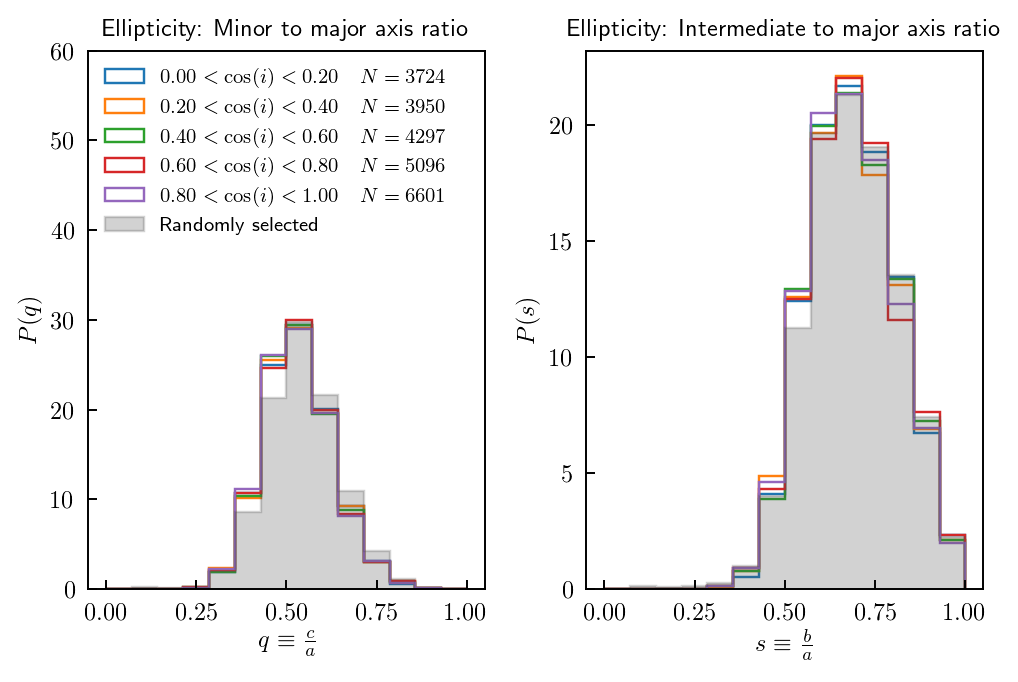

In [151]:
#Plotting by cos_i bins
fig, axs = plt.subplots(1, 2, tight_layout=True)
num_bin = np.linspace(0.0,1.0,15) #num_bin = 13
for i, cosi_bin_ind in enumerate(cosi_bins_ind):
    cosi_bin_num = len(cosi_bin_ind[0])
    cosi_bin_min = cosi_bins[i][0]; cosi_bin_max = cosi_bins[i][1]
    
    #Convert to probability in each bin
    weights = np.ones_like(q[cosi_bin_ind], dtype=float)/cosi_bin_num * 100
    #print weights
    axs[0].hist(q[cosi_bin_ind], num_bin, density=False, fill=False, weights=weights, histtype='step', \
               label=r'${:.2f}< \cos(i) < {:.2f}\quad N = {:d}$'.format(cosi_bin_min, cosi_bin_max, cosi_bin_num)) 

    b =axs[1].hist(s[cosi_bin_ind], num_bin, density=False, fill=False, weights=weights, histtype='step', \
               label=r'${:.2f}< \cos(i) < {:.2f}\quad N = {:d}$'.format(cosi_bin_min, cosi_bin_max, cosi_bin_num)) 
    
#Plotting random halos
weights = np.ones_like(q_rand)/(len(q_rand)) * 100
axs[0].hist(q_rand, num_bin, density=False, weights=weights, fill=True, histtype='step', color='0.3', \
               label='Randomly selected', alpha=0.25) 
weights = np.ones_like(s_rand)/(len(s_rand)) * 100
a =axs[1].hist(s_rand, num_bin, density=False, weights=weights, fill=True, histtype='step', color='0.3', \
               label='Randomly selected', alpha=0.25) 

#Plot config   
axs[0].set_xlabel(r'$q \equiv \frac{c}{a}$')
axs[0].set_ylabel('$P(q)$')
axs[0].set_title(r'Ellipticity: Minor to major axis ratio', fontsize=10)

axs[0].set_ylim((0,60))
axs[0].legend(loc='upper left', fontsize=8, frameon=False)

axs[1].set_xlabel(r'$s \equiv \frac{b}{a}$')
axs[1].set_ylabel('$P(s)$')
axs[1].set_title(r'Ellipticity: Intermediate to major axis ratio', fontsize=10)
#plt.savefig('ellipticity_032018.png')
plt.show()


[Text(0,0,'$\\cos(i) \\in [0.0, 0.2)$'),
 Text(0,0,'$\\cos(i) \\in [0.2, 0.4)$'),
 Text(0,0,'$\\cos(i) \\in [0.4, 0.6)$'),
 Text(0,0,'$\\cos(i) \\in [0.6, 0.8)$'),
 Text(0,0,'$\\cos(i) \\in [0.8, 1.0)$')]

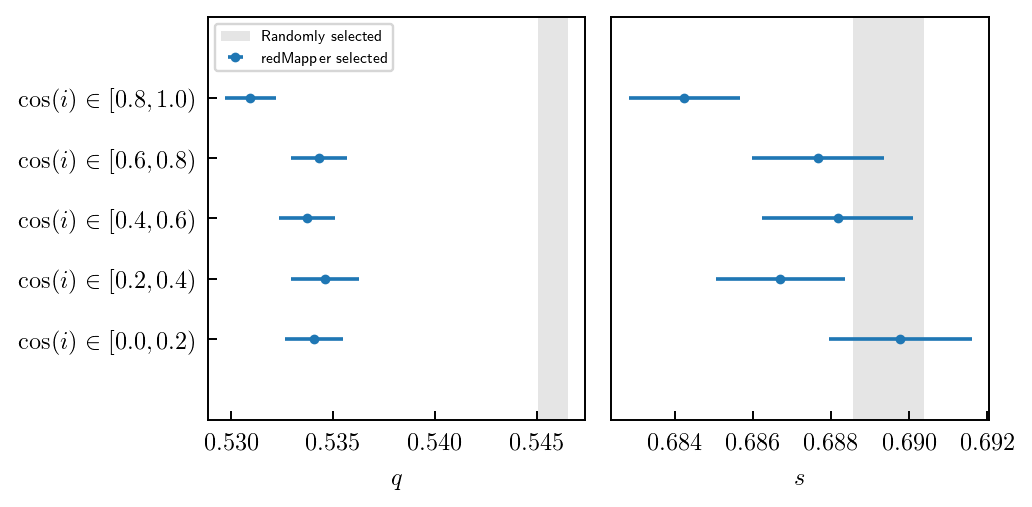

In [152]:
#Plotting error bars
#num_stat-1 to not show the cos_i mean
fig, axs = plt.subplots(1 ,num_stat-1, tight_layout=True, figsize=(6,3))

#ax.fill_between(x, y1, y2, where=y2 >= y1, facecolor='green', interpolate=True)
#ax.fill_between(x, y1, y2, where=y2 <= y1, facecolor='red', interpolate=True)
num_bins = len(cosi_bins)
yticks = np.linspace(0.2,0.8 , num_bins)
yticklabels = []
xlabels = [r'$q$', r'$s$', r'$\cos(i)$']
for i, cosi_bin_i in enumerate(cosi_bins):
    yticklabels_i = r'$\cos(i) \in [{:.1f}, {:.1f})$'.format(cosi_bin_i[0], cosi_bin_i[1])
    yticklabels.append(yticklabels_i)

for i, name in enumerate(T_stat_arr.dtype.names):
    if name=='cos_i': #Don't plot cos_i. 
        continue

    #Consider as a next step combining ONLY data that are consistent. 
    SE_combine = np.sqrt(np.sum([T_stat_arr[name][:,2]])) 
    stat_tot_num = np.sum([T_stat_arr[name][:,1]])
    
    axs[i].bar(T_stat_arr_rand[name][0,0], height=1, width=T_stat_arr_rand[name][0,2], alpha=0.2, color='gray',label='Randomly selected')
    axs[i].errorbar(T_stat_arr[name][:,0],yticks, xerr=T_stat_arr[name][:,2], fmt='o', markersize=3, label='redMapper selected')
    axs[i].set_xlabel(xlabels[i])
    axs[i].set_yticks([])
    axs[i].set_ylim((0.0,1.0))
    
axs[0].legend(fontsize=6, loc='best')
axs[0].set_yticks(yticks)
axs[0].set_yticklabels(yticklabels)
